In [1]:
import polars as pl

DATA_PATH = "../../data/"

train = pl.read_csv(DATA_PATH + "train.csv")
predicted_prompt = pl.read_csv(DATA_PATH + "predicted_prompt.csv")

In [2]:
train

essay_id,full_text,score
str,str,i64
"""000d118""","""Many people have car where the…",3
"""000fe60""","""I am a scientist at NASA that …",3
"""001ab80""","""People always wish they had th…",4
"""001bdc0""","""We all heard about Venus, the …",4
"""002ba53""","""Dear, State Senator This is a…",3
…,…,…
"""ffd378d""","""the story "" The Challenge of E…",2
"""ffddf1f""","""Technology has changed a lot o…",4
"""fff016d""","""If you don't like sitting arou…",2


In [3]:
train = train.join(  # prompt_nameを付与する
    predicted_prompt.select(pl.col(["essay_id", "prompt_name"])),
    how="left",
    on="essay_id",
)

In [4]:
from datasets import load_dataset

# 追加データ
persuade_dataset = (
    load_dataset(
        "csv",
        data_files={"train": f"{DATA_PATH}/persuade_w_is_tr_con_as_num.csv"},
        split="train",
    )
    .filter(lambda x: not x["is_train_contains"])
    .select_columns(
        ["essay_id_comp", "full_text", "holistic_essay_score", "prompt_name"]
    )
    .rename_columns({"essay_id_comp": "essay_id", "holistic_essay_score": "score"})
)

persuade_df = pl.DataFrame(persuade_dataset.to_pandas())

/Users/shinichiro.saito/automated_essay_scoring/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train = pl.concat([train, persuade_df])

train = train.with_columns(  # prompt_nameをlabel encodingする
    pl.col("prompt_name").cast(pl.Categorical).to_physical().alias("prompt_id")
)

In [6]:
pl.Config.set_tbl_rows(100)

polars.config.Config

In [7]:
train = train.with_columns(
    pl.col("full_text")
    .map_elements(lambda x: len(x.split()), return_dtype=pl.Int64)
    .alias("word_length"),
)

<Axes: xlabel='word_length', ylabel='score'>

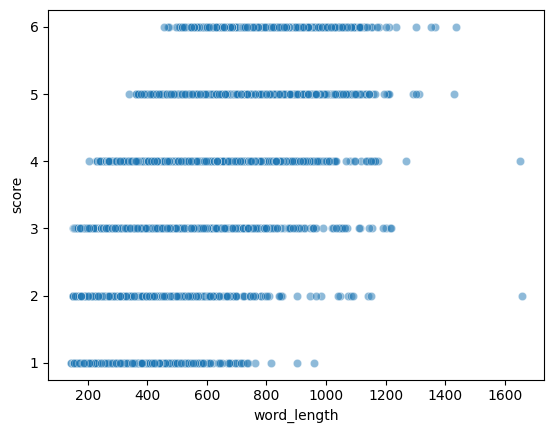

In [8]:
import seaborn as sns

sns.scatterplot(train.to_pandas(), x="word_length", y="score", alpha=0.5)

In [9]:
train = train.with_columns(
    pl.when(pl.col("word_length") <= 200)
    .then(pl.lit("x<=200"))
    .when(pl.col("word_length") <= 400)
    .then(pl.lit("200<x<=400"))
    .when(pl.col("word_length") <= 600)
    .then(pl.lit("400<x<=600"))
    .when(pl.col("word_length") <= 800)
    .then(pl.lit("600<x<=800"))
    .when(pl.col("word_length") <= 1000)
    .then(pl.lit("800<x<=1000"))
    .when(pl.col("word_length") <= 1200)
    .then(pl.lit("1000<x<=1200"))
    .when(pl.col("word_length") > 1200)
    .then(pl.lit("x>1200"))
    .alias("word_length_cat"),
)

In [10]:
train = train.with_columns(
    pl.concat_str(
        pl.col("score"),
        pl.col("word_length_cat"),
        separator="_",
    ).alias("score_word_length_cat")
).with_columns(
    pl.concat_str(
        pl.col("score_word_length_cat"),
        pl.col("prompt_id"),
        separator="_",
    ).alias("concat_score_word_length_prompt_id")
)

In [11]:
train.head(10)

essay_id,full_text,score,prompt_name,prompt_id,word_length,word_length_cat,score_word_length_cat,concat_score_word_length_prompt_id
str,str,i64,str,u32,i64,str,str,str
"""000d118""","""Many people have car where the…",3,"""Car-free cities""",0,498,"""400<x<=600""","""3_400<x<=600""","""3_400<x<=600_0"""
"""000fe60""","""I am a scientist at NASA that …",3,"""The Face on Mars""",1,332,"""200<x<=400""","""3_200<x<=400""","""3_200<x<=400_1"""
"""001ab80""","""People always wish they had th…",4,"""Driverless cars""",2,550,"""400<x<=600""","""4_400<x<=600""","""4_400<x<=600_2"""
"""001bdc0""","""We all heard about Venus, the …",4,"""Exploring Venus""",3,451,"""400<x<=600""","""4_400<x<=600""","""4_400<x<=600_3"""
"""002ba53""","""Dear, State Senator This is a…",3,"""Does the electoral college wor…",4,373,"""200<x<=400""","""3_200<x<=400""","""3_200<x<=400_4"""
"""0030e86""","""If I were to choose between ke…",4,"""Does the electoral college wor…",4,400,"""200<x<=400""","""4_200<x<=400""","""4_200<x<=400_4"""
"""0033037""","""The posibilty of a face reconi…",2,"""Facial action coding system""",5,179,"""x<=200""","""2_x<=200""","""2_x<=200_5"""
"""0033bf4""","""What is the Seagoing Cowboys p…",3,"""""A Cowboy Who Rode the Waves""""",6,353,"""200<x<=400""","""3_200<x<=400""","""3_200<x<=400_6"""
"""0036253""","""The challenge of exploring Ven…",2,"""Exploring Venus""",3,310,"""200<x<=400""","""2_200<x<=400""","""2_200<x<=400_3"""


In [12]:
(
    train.select(
        pl.col("concat_score_word_length_prompt_id").value_counts(),
    )
    .unnest("concat_score_word_length_prompt_id")
    .with_columns((pl.col("count") / train.height).alias("percentage"))
    .sort("count", descending=True)
)

concat_score_word_length_prompt_id,count,percentage
str,u32,f64
"""3_200<x<=400_2""",954,0.031349
"""3_200<x<=400_5""",910,0.029903
"""4_400<x<=600_2""",779,0.025598
"""3_200<x<=400_3""",737,0.024218
"""3_200<x<=400_12""",667,0.021918
"""3_200<x<=400_1""",617,0.020275
"""2_200<x<=400_3""",576,0.018927
"""3_200<x<=400_11""",550,0.018073
"""3_200<x<=400_10""",528,0.01735


In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

fold_arr = np.zeros(train.height)
sgkf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for idx, (_, val_idx) in enumerate(
    sgkf.split(train, train["concat_score_word_length_prompt_id"])
):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

/Users/shinichiro.saito/automated_essay_scoring/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [14]:
train.head(10)

essay_id,full_text,score,prompt_name,prompt_id,word_length,word_length_cat,score_word_length_cat,concat_score_word_length_prompt_id,fold
str,str,i64,str,u32,i64,str,str,str,i64
"""000d118""","""Many people have car where the…",3,"""Car-free cities""",0,498,"""400<x<=600""","""3_400<x<=600""","""3_400<x<=600_0""",0
"""000fe60""","""I am a scientist at NASA that …",3,"""The Face on Mars""",1,332,"""200<x<=400""","""3_200<x<=400""","""3_200<x<=400_1""",2
"""001ab80""","""People always wish they had th…",4,"""Driverless cars""",2,550,"""400<x<=600""","""4_400<x<=600""","""4_400<x<=600_2""",2
"""001bdc0""","""We all heard about Venus, the …",4,"""Exploring Venus""",3,451,"""400<x<=600""","""4_400<x<=600""","""4_400<x<=600_3""",2
"""002ba53""","""Dear, State Senator This is a…",3,"""Does the electoral college wor…",4,373,"""200<x<=400""","""3_200<x<=400""","""3_200<x<=400_4""",1
"""0030e86""","""If I were to choose between ke…",4,"""Does the electoral college wor…",4,400,"""200<x<=400""","""4_200<x<=400""","""4_200<x<=400_4""",0
"""0033037""","""The posibilty of a face reconi…",2,"""Facial action coding system""",5,179,"""x<=200""","""2_x<=200""","""2_x<=200_5""",0
"""0033bf4""","""What is the Seagoing Cowboys p…",3,"""""A Cowboy Who Rode the Waves""""",6,353,"""200<x<=400""","""3_200<x<=400""","""3_200<x<=400_6""",0
"""0036253""","""The challenge of exploring Ven…",2,"""Exploring Venus""",3,310,"""200<x<=400""","""2_200<x<=400""","""2_200<x<=400_3""",1


In [15]:
essay_id_fold_dict = dict(zip(train["essay_id"], train["fold"]))

import json

with open("essay_id_fold_by_slp_dict.json", "w") as f:
    # slt = score length topic
    json.dump(essay_id_fold_dict, f)

# Check

In [16]:
(
    train.filter(pl.col("fold") == 0)
    .select(
        pl.col("concat_score_word_length_prompt_id").value_counts(),
    )
    .unnest("concat_score_word_length_prompt_id")
    .with_columns((pl.col("count") / train.height).alias("percentage"))
    .sort("count", descending=True)
    .head(10)
)

concat_score_word_length_prompt_id,count,percentage
str,u32,f64
"""3_200<x<=400_2""",318,0.01045
"""3_200<x<=400_5""",304,0.009989
"""4_400<x<=600_2""",260,0.008544
"""3_200<x<=400_3""",245,0.008051
"""3_200<x<=400_12""",222,0.007295
"""3_200<x<=400_1""",206,0.006769
"""2_200<x<=400_3""",192,0.006309
"""3_200<x<=400_11""",184,0.006046
"""3_200<x<=400_10""",176,0.005783


In [17]:
(
    train.filter(pl.col("fold") == 1)
    .select(
        pl.col("concat_score_word_length_prompt_id").value_counts(),
    )
    .unnest("concat_score_word_length_prompt_id")
    .with_columns((pl.col("count") / train.height).alias("percentage"))
    .sort("count", descending=True)
    .head(10)
)

concat_score_word_length_prompt_id,count,percentage
str,u32,f64
"""3_200<x<=400_2""",318,0.01045
"""3_200<x<=400_5""",303,0.009957
"""4_400<x<=600_2""",259,0.008511
"""3_200<x<=400_3""",246,0.008084
"""3_200<x<=400_12""",222,0.007295
"""3_200<x<=400_1""",206,0.006769
"""2_200<x<=400_3""",192,0.006309
"""3_200<x<=400_11""",183,0.006013
"""3_200<x<=400_10""",176,0.005783


In [18]:
# (
#     train.filter(pl.col("fold") == 0)
#     .select(
#         pl.col("score").value_counts(),
#     )
#     .unnest("score")
#     .with_columns((pl.col("count") / train.height).alias("percentage"))
#     .sort("count", descending=True)
# )

In [19]:
# (
#     train.filter(pl.col("fold") == 0)
#     .select(
#         pl.col("word_length_cat").value_counts(),
#     )
#     .unnest("word_length_cat")
#     .with_columns((pl.col("count") / train.height).alias("percentage"))
#     .sort("count", descending=True)
# )

In [20]:
# (
#     train.filter(pl.col("fold") == 1)
#     .select(
#         pl.col("word_length_cat").value_counts(),
#     )
#     .unnest("word_length_cat")
#     .with_columns((pl.col("count") / train.height).alias("percentage"))
#     .sort("count", descending=True)
# )